## FLOWRRA - Prototype

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Constants
GRID_SIZE = 30
NUM_NODES = 12
ANGLE_STEPS = 36  # i.e. 360/10 = 36 directions



class DiskNode:
    def __init__(self, node_id, position, eye_angle_idx):
        self.id = node_id
        self.position = position  # (x, y)
        self.eye_angle_idx = eye_angle_idx  # index from 0 to 35
        self.connected_to = None  # another DiskNode ID

    def rotate_eye(self, delta=1):
        self.eye_angle_idx = (self.eye_angle_idx + delta) % ANGLE_STEPS

    def eye_direction(self):
        angle_deg = self.eye_angle_idx * 10
        rad = np.deg2rad(angle_deg)
        return np.cos(rad), np.sin(rad)




In [2]:
# ------------------------------------------------
# ENVIRONMENT A + AGENT LOOP (Unified)
# ------------------------------------------------


class LoopAgent:
    def __init__(self, grid_size, num_nodes, num_blocks=20):
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))
        self.blocks = self.generate_obstacles(num_blocks)
        self.nodes = []
        self.wave_history = []
        self.initialize_nodes(num_nodes)
        self.construct_initial_loop()

    def generate_obstacles(self, num_blocks):
        blocks = set()
        while len(blocks) < num_blocks:
            x, y = random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)
            blocks.add((x, y))
        for x, y in blocks:
            self.grid[x][y] = -1  # Mark as obstacle
        return blocks

    def initialize_nodes(self, num_nodes):
        positions = self.get_valid_positions(num_nodes)
        for i, pos in enumerate(positions):
            angle_idx = random.randint(0, ANGLE_STEPS-1)
            self.nodes.append(DiskNode(i, pos, angle_idx))

    def get_valid_positions(self, num_nodes):
        positions = set()
        while len(positions) < num_nodes:
            x, y = random.randint(1, self.grid_size - 2), random.randint(1, self.grid_size - 2)
            if (x, y) not in self.blocks:
                positions.add((x, y))
        return list(positions)

    def construct_initial_loop(self):
        for i in range(len(self.nodes)):
            self.nodes[i].connected_to = self.nodes[(i+1) % len(self.nodes)].id
        self.update_wave_function()

    def update_wave_function(self):
        coherence = self.compute_coherence()
        wave = {
            'time': len(self.wave_history),
            'coherence': coherence,
            'states': [(n.position, n.eye_angle_idx) for n in self.nodes]
        }
        self.wave_history.append(wave)

    def compute_coherence(self):
        aligned = 0
        for node in self.nodes:
            target_id = node.connected_to
            if target_id is None: continue
            target = self.nodes[target_id]
            dx, dy = target.position[0] - node.position[0], target.position[1] - node.position[1]
            vx, vy = node.eye_direction()
            dot_product = dx * vx + dy * vy
            distance = np.linalg.norm([dx, dy]) + 1e-5
            alignment_score = dot_product / distance
            if alignment_score > 0.5:  # threshold for "good enough"
                aligned += 1
        return aligned / len(self.nodes)

    def step(self, noise=0.1):
        for node in self.nodes:
            if random.random() < noise:
                node.rotate_eye(random.choice([-1, 1]))
        self.update_wave_function()

    def disturb(self, kind="remove"):
        if kind == "remove":
            if len(self.nodes) > 3:
                idx = random.randint(0, len(self.nodes) - 1)
                self.nodes.pop(idx)
                # re-wire loop
                for i in range(len(self.nodes)):
                    self.nodes[i].connected_to = self.nodes[(i + 1) % len(self.nodes)].id
        elif kind == "rotate":
            for _ in range(3):
                node = random.choice(self.nodes)
                node.rotate_eye(random.randint(5, 15))  # large disturbance
        self.update_wave_function()

    def retrocollapse(self):
        if len(self.wave_history) < 2:
            return
        prev_state = self.wave_history[-2]['states']
        for i, node in enumerate(self.nodes):
            if i >= len(prev_state):
                continue
            pos, angle = prev_state[i]
            # Partial collapse with stochasticity
            if random.random() < 0.7:
                node.eye_angle_idx = angle
        self.update_wave_function()


Disturbing...
Retro-causal Collapse initiated...


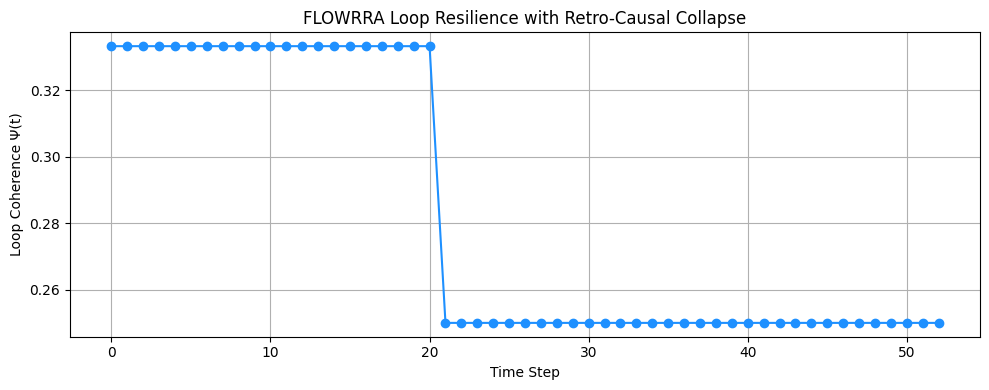

In [3]:

def run_simulation():
    agent = LoopAgent(grid_size=GRID_SIZE, num_nodes=NUM_NODES, num_blocks=25)
    
    for t in range(50):
        if t == 20:
            print("Disturbing...")
            agent.disturb(kind="rotate")
        if t == 25:
            print("Retro-causal Collapse initiated...")
            agent.retrocollapse()
        agent.step()

    # Visualize coherence
    coherence_vals = [w['coherence'] for w in agent.wave_history]
    plt.figure(figsize=(10, 4))
    plt.plot(coherence_vals, marker='o', linestyle='-', color='dodgerblue')
    plt.xlabel("Time Step")
    plt.ylabel("Loop Coherence Ψ(t)")
    plt.title("FLOWRRA Loop Resilience with Retro-Causal Collapse")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

run_simulation()


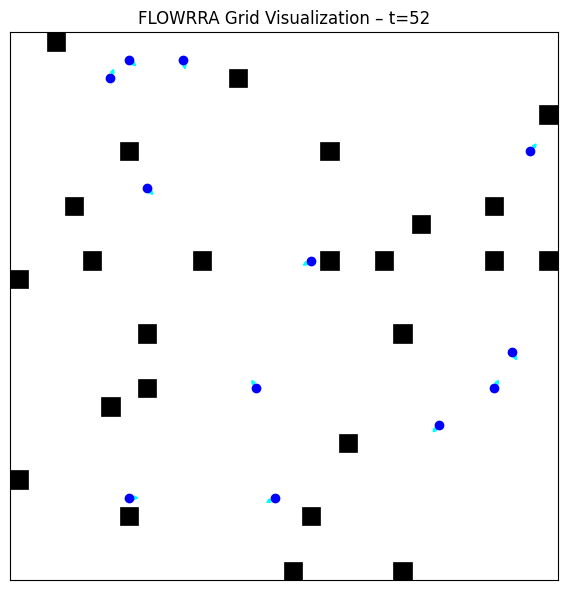

In [6]:
#Visualization

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_grid(agent, timestep):
    agent = agent
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, agent.grid_size)
    ax.set_ylim(0, agent.grid_size)
    ax.set_title(f"FLOWRRA Grid Visualization – t={timestep}")
    ax.set_xticks([])
    ax.set_yticks([])

    # Draw obstacles
    for (x, y) in agent.blocks:
        rect = patches.Rectangle((x, y), 1, 1, linewidth=0.5, edgecolor='black', facecolor='red')
        ax.add_patch(rect)

    # Draw nodes and their eye directions
    for node in agent.nodes:
        x, y = node.position
        dx, dy = node.eye_direction()
        ax.plot(x + 0.5, y + 0.5, 'bo')  # Disk center
        ax.arrow(x + 0.5, y + 0.5, 0.3 * dx, 0.3 * dy, head_width=0.2, head_length=0.2, fc='cyan', ec='cyan')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

# Show the grid at the last timestep
visualize_grid(agent, timestep=len(agent.wave_history) - 1)


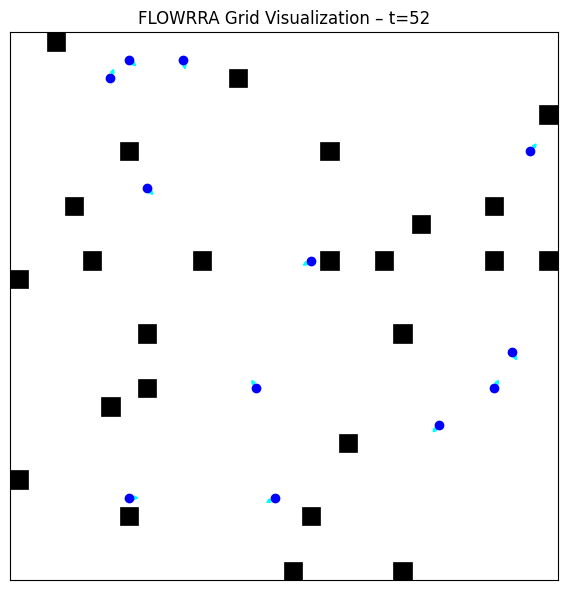

In [5]:
# Recreate the agent and run simulation again to regenerate the environment
agent = LoopAgent(grid_size=GRID_SIZE, num_nodes=NUM_NODES, num_blocks=25)

for t in range(50):
    if t == 20:
        agent.disturb(kind="rotate")
    if t == 25:
        agent.retrocollapse()
    agent.step()

# Now visualize the final grid state with disk positions and directions
visualize_grid(agent, timestep=len(agent.wave_history) - 1)


### Step-1
- Constructing the 2D-Grid of 30x30.
- Constructing disks with eyes and placing them in a loop.
    - Eyes of each disk are directed to form a loop.

In [ ]:
# Constants
GRID_SIZE = 30
NUM_NODES = 12
ANGLE_STEPS = 36  # i.e. 360/10 = 36 directions

In [7]:
#making the Disk
class DiskNode:
    def __init__(self, node_id, position, eye_angle_idx):
        self.id = node_id
        self.position = position  # (x, y)
        self.eye_angle_idx = eye_angle_idx  # index from 0 to 35
        self.connected_to = None  # another DiskNode ID

    def rotate_eye(self, delta=1):
        self.eye_angle_idx = (self.eye_angle_idx + delta) % ANGLE_STEPS

    def eye_direction(self):
        angle_deg = self.eye_angle_idx * 10
        rad = np.deg2rad(angle_deg)
        return np.cos(rad), np.sin(rad)

In [ ]:
#Making the 2D-Grid
grid_size = grid_size
grid = np.zeros((grid_size, grid_size))

In [ ]:
def generate_obstacles(self, num_blocks):
    blocks = set()
    while len(blocks) < num_blocks:
        x, y = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
        blocks.add((x, y))
    for x, y in blocks:
        grid[x][y] = -1  # Mark as obstacle
    return blocks

In [ ]:
def initialize_nodes(self, num_nodes):
    positions = self.get_valid_positions(num_nodes)
    for i, pos in enumerate(positions):
        angle_idx = random.randint(0, ANGLE_STEPS-1)
        self.nodes.append(DiskNode(i, pos, angle_idx))

def get_valid_positions(self, num_nodes):
    positions = set()
    while len(positions) < num_nodes:
        x, y = random.randint(1, self.grid_size - 2), random.randint(1, self.grid_size - 2)
        if (x, y) not in self.blocks:
            positions.add((x, y))
    return list(positions)

def construct_initial_loop(self):
    for i in range(len(self.nodes)):
        self.nodes[i].connected_to = self.nodes[(i+1) % len(self.nodes)].id
    return True

In [ ]:
blocks = self.generate_obstacles(num_blocks)
nodes = []
initialize_nodes(num_nodes)
construct_initial_loop()